In [1]:
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting



import warnings
warnings.filterwarnings('ignore')


### sites

In [2]:
ctcf_path='/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14'
ctcf = bioframe.read_table(ctcf_path+'/CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed', schema='bed')

RAD21=bioframe.read_table(ctcf_path+'/RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed', schema='bed')
RAD21['mid']=(RAD21.end+RAD21.start)/2
ctcf['mid']=(ctcf.end+ctcf.start)/2

### ctcf

In [3]:
ctcf

,chrom,start,end,name,score,strand,mid
0,chr1,4142490,4142913,CTCF_4reps_peak_2,64.65743,NaN,4142701.5
1,chr1,4332483,4332832,CTCF_4reps_peak_5,39.08555,NaN,4332657.5
2,chr1,4346148,4346563,CTCF_4reps_peak_6,79.91960,NaN,4346355.5
3,chr1,4416660,4417109,CTCF_4reps_peak_8,96.79732,NaN,4416884.5
4,chr1,4491865,4492386,CTCF_4reps_peak_9,84.59853,NaN,4492125.5
...,...,...,...,...,...,...,...
45834,chrX,168673401,168673773,CTCF_4reps_peak_69563,33.27952,NaN,168673587.0
45835,chrX,169036508,169037081,CTCF_4reps_peak_69567,36.41209,NaN,169036794.5
45836,chrX,169085920,169086223,CTCF_4reps_peak_69568,26.15091,NaN,169086071.5
45837,chrY,872918,873242,CTCF_4reps_peak_69577,32.47781,NaN,873080.0


In [4]:
ctcf['quartile_score']=pd.qcut(ctcf['score'],4, labels=False) + 1

In [5]:
ctcf_quart=ctcf[ctcf['quartile_score']==4]

In [6]:
ctcf_quart

,chrom,start,end,name,score,strand,mid,quartile_score
3,chr1,4416660,4417109,CTCF_4reps_peak_8,96.79732,NaN,4416884.5,4
4,chr1,4491865,4492386,CTCF_4reps_peak_9,84.59853,NaN,4492125.5,4
31,chr1,7396871,7397626,CTCF_4reps_peak_52,105.31587,NaN,7397248.5,4
32,chr1,7398126,7398638,CTCF_4reps_peak_53,100.37192,NaN,7398382.0,4
37,chr1,9469388,9469849,CTCF_4reps_peak_60,98.75822,NaN,9469618.5,4
...,...,...,...,...,...,...,...,...
45756,chrX,159409277,159409678,CTCF_4reps_peak_69425,83.02445,NaN,159409477.5,4
45760,chrX,159532306,159532777,CTCF_4reps_peak_69433,128.08290,NaN,159532541.5,4
45768,chrX,159987852,159988452,CTCF_4reps_peak_69443,153.57147,NaN,159988152.0,4
45814,chrX,164269160,164269649,CTCF_4reps_peak_69520,92.93923,NaN,164269404.5,4


### ctcf from JASPAR data

In [7]:
direct='/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz'

In [8]:
motif=bioframe.read_table(direct)

In [9]:
motif.head()

,0,1,2,3,4,5,6
0,chr10,3103662,3103681,CTCF,814,410,-
1,chr10,3108121,3108140,CTCF,859,504,-
2,chr10,3119020,3119039,CTCF,801,386,-
3,chr10,3124081,3124100,CTCF,807,397,-
4,chr10,3127081,3127100,CTCF,810,403,+


In [10]:
motif=motif.rename(columns={0: 'chrom', 1: 'start',2:'end',3:'name',4:'score',5:'pval',6:'strand'})
motif

,chrom,start,end,name,score,pval,strand
0,chr10,3103662,3103681,CTCF,814,410,-
1,chr10,3108121,3108140,CTCF,859,504,-
2,chr10,3119020,3119039,CTCF,801,386,-
3,chr10,3124081,3124100,CTCF,807,397,-
4,chr10,3127081,3127100,CTCF,810,403,+
...,...,...,...,...,...,...,...
825505,chrY,90829177,90829196,CTCF,842,465,+
825506,chrY,90839573,90839592,CTCF,804,392,+
825507,chrY,90839785,90839804,CTCF,885,565,-
825508,chrY,90839787,90839806,CTCF,842,465,+


In [11]:
motif['quartile_score']=pd.qcut(motif['score'],4,labels=False) + 1
motif

,chrom,start,end,name,score,pval,strand,quartile_score
0,chr10,3103662,3103681,CTCF,814,410,-,2
1,chr10,3108121,3108140,CTCF,859,504,-,4
2,chr10,3119020,3119039,CTCF,801,386,-,1
3,chr10,3124081,3124100,CTCF,807,397,-,1
4,chr10,3127081,3127100,CTCF,810,403,+,2
...,...,...,...,...,...,...,...,...
825505,chrY,90829177,90829196,CTCF,842,465,+,4
825506,chrY,90839573,90839592,CTCF,804,392,+,1
825507,chrY,90839785,90839804,CTCF,885,565,-,4
825508,chrY,90839787,90839806,CTCF,842,465,+,4


In [12]:
motif_quart=motif[motif['quartile_score']==4]
motif_quart

,chrom,start,end,name,score,pval,strand,quartile_score
1,chr10,3108121,3108140,CTCF,859,504,-,4
6,chr10,3136802,3136821,CTCF,876,543,+,4
19,chr10,3202574,3202593,CTCF,844,470,-,4
24,chr10,3218832,3218851,CTCF,842,465,+,4
27,chr10,3229366,3229385,CTCF,869,527,+,4
...,...,...,...,...,...,...,...,...
825503,chrY,90828914,90828933,CTCF,861,506,+,4
825504,chrY,90829175,90829194,CTCF,885,565,-,4
825505,chrY,90829177,90829196,CTCF,842,465,+,4
825507,chrY,90839785,90839804,CTCF,885,565,-,4


### overlap

In [13]:
peaks_motifs = bioframe.overlap(ctcf,motif,how='inner')

In [14]:
peaks_motifs = peaks_motifs[(peaks_motifs['chrom']!= 'chrX')&(peaks_motifs['chrom']!= 'chrY')]
peaks_motifs

,chrom,start,end,name,score,strand,mid,quartile_score,chrom_,start_,end_,name_,score_,pval_,strand_,quartile_score_
0,chr7,3106509,3106887,CTCF_4reps_peak_55712,54.28935,NaN,3106698.0,2,chr7,3106696,3106715,CTCF,947,755,-,4
1,chr7,3143339,3143702,CTCF_4reps_peak_55713,38.01946,NaN,3143520.5,2,chr7,3143519,3143538,CTCF,880,551,-,4
2,chr7,3164035,3164375,CTCF_4reps_peak_55714,32.91024,NaN,3164205.0,1,chr7,3164201,3164220,CTCF,872,532,+,4
3,chr7,3172688,3172919,CTCF_4reps_peak_55715,14.06889,NaN,3172803.5,1,chr7,3172796,3172815,CTCF,869,525,+,4
4,chr7,3173501,3173944,CTCF_4reps_peak_55716,26.56207,NaN,3173722.5,1,chr7,3173687,3173706,CTCF,894,589,+,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55068,chr16,30570117,30570559,CTCF_4reps_peak_24753,44.64270,NaN,30570338.0,2,chr16,30570110,30570129,CTCF,831,444,-,3
55069,chr16,31980810,31981394,CTCF_4reps_peak_24811,77.29397,NaN,31981102.0,3,chr16,31980807,31980826,CTCF,861,507,+,4
55070,chr16,32715983,32716349,CTCF_4reps_peak_24877,36.26369,NaN,32716166.0,2,chr16,32715972,32715991,CTCF,813,408,+,2
55071,chr16,42207160,42207657,CTCF_4reps_peak_25192,25.35579,NaN,42207408.5,1,chr16,42207153,42207172,CTCF,831,443,+,3


In [15]:
peaks_motifs[peaks_motifs['strand_']=='NAN']

,chrom,start,end,name,score,strand,mid,quartile_score,chrom_,start_,end_,name_,score_,pval_,strand_,quartile_score_


In [16]:
peaks_motifs=peaks_motifs.rename(columns={'strand':'strand_','strand_':'strand'})

In [17]:
peaks_motifs=peaks_motifs[['chrom','start','end','name','score','mid','quartile_score','strand']]
peaks_motifs

,chrom,start,end,name,score,mid,quartile_score,strand
0,chr7,3106509,3106887,CTCF_4reps_peak_55712,54.28935,3106698.0,2,-
1,chr7,3143339,3143702,CTCF_4reps_peak_55713,38.01946,3143520.5,2,-
2,chr7,3164035,3164375,CTCF_4reps_peak_55714,32.91024,3164205.0,1,+
3,chr7,3172688,3172919,CTCF_4reps_peak_55715,14.06889,3172803.5,1,+
4,chr7,3173501,3173944,CTCF_4reps_peak_55716,26.56207,3173722.5,1,+
...,...,...,...,...,...,...,...,...
55068,chr16,30570117,30570559,CTCF_4reps_peak_24753,44.64270,30570338.0,2,-
55069,chr16,31980810,31981394,CTCF_4reps_peak_24811,77.29397,31981102.0,3,+
55070,chr16,32715983,32716349,CTCF_4reps_peak_24877,36.26369,32716166.0,2,+
55071,chr16,42207160,42207657,CTCF_4reps_peak_25192,25.35579,42207408.5,1,+


### overlap, quartile

In [18]:
peaks_motifs_quartile= bioframe.overlap(ctcf_quart,motif_quart,how='inner')
peaks_motifs_quartile

,chrom,start,end,name,score,strand,mid,quartile_score,chrom_,start_,end_,name_,score_,pval_,strand_,quartile_score_
0,chr7,3262756,3263482,CTCF_4reps_peak_55727,89.04897,NaN,3263119.0,4,chr7,3262985,3263004,CTCF,949,764,-,4
1,chr7,3262756,3263482,CTCF_4reps_peak_55727,89.04897,NaN,3263119.0,4,chr7,3263373,3263392,CTCF,849,480,+,4
2,chr7,3376861,3377234,CTCF_4reps_peak_55741,98.85757,NaN,3377047.5,4,chr7,3377056,3377075,CTCF,879,550,-,4
3,chr7,3578188,3578645,CTCF_4reps_peak_55755,121.67102,NaN,3578416.5,4,chr7,3578359,3578378,CTCF,857,498,+,4
4,chr7,3578188,3578645,CTCF_4reps_peak_55755,121.67102,NaN,3578416.5,4,chr7,3578397,3578416,CTCF,873,536,-,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11723,chr16,96467346,96467859,CTCF_4reps_peak_26082,110.54472,NaN,96467602.5,4,chr16,96467585,96467604,CTCF,842,465,+,4
11724,chr16,97272270,97272688,CTCF_4reps_peak_26102,93.20385,NaN,97272479.0,4,chr16,97272469,97272488,CTCF,922,669,-,4
11725,chr16,97293283,97293719,CTCF_4reps_peak_26103,93.96867,NaN,97293501.0,4,chr16,97293509,97293528,CTCF,927,686,-,4
11726,chr16,97312787,97313492,CTCF_4reps_peak_26105,84.33813,NaN,97313139.5,4,chr16,97313041,97313060,CTCF,921,667,+,4


In [19]:
peaks_motifs_quartile=peaks_motifs_quartile.rename(columns={'strand':'strand_','strand_':'strand'})

In [20]:
peaks_motifs_quartile=peaks_motifs_quartile[['chrom','start','end','score','strand','score_','pval_']]
peaks_motifs_quartile

,chrom,start,end,score,strand,score_,pval_
0,chr7,3262756,3263482,89.04897,-,949,764
1,chr7,3262756,3263482,89.04897,+,849,480
2,chr7,3376861,3377234,98.85757,-,879,550
3,chr7,3578188,3578645,121.67102,+,857,498
4,chr7,3578188,3578645,121.67102,-,873,536
...,...,...,...,...,...,...,...
11723,chr16,96467346,96467859,110.54472,+,842,465
11724,chr16,97272270,97272688,93.20385,-,922,669
11725,chr16,97293283,97293719,93.96867,-,927,686
11726,chr16,97312787,97313492,84.33813,+,921,667


### loading contact data, Bonev

In [21]:
# high-resolution reprocessed publically-available data from Bonev et al. 2017
res = 10_000
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))
view_df_bonev = cooltools.lib.make_cooler_view(bonev_cooler)[:19]

### loading data, Liu_deWit

In [22]:
# data from Liu& deWit et al. 
prefix_dir_liu = '/project/fudenber_735/GEO/liu_deWit_GSE181848/'
cooler_prefix_liu = prefix_dir_liu
sample_dict_liu ={
    'Wapl-0h':'GSM5512837_HiC.01_WAPL_0h.mcool',
    'Wapl-6h':'GSM5512838_HiC.02_WAPL_6h.mcool'
}
sample='Wapl-6h'
mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]

In [23]:
# data from Liu 2021
prefix_dir_liu_new = '/project/fudenber_735/GEO/liu_deWit_2021_GSE135180/distiller-mm10/results/coolers_library/'
cooler_prefix_liu_new = prefix_dir_liu_new
sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}
sample='Wapl-24h_new'
mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
liu_new_cooler = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
view_df_liu_new = cooltools.lib.make_cooler_view(liu_new_cooler)[:19]

### piling up, peaks_motifs overlap

In [24]:
sites=peaks_motifs.copy()
flank_bp=100_000
mindist=90_000
band_edges = np.append([mindist], mindist+4000 * 1.3 ** np.arange(1,19))
band_edge_list=list(band_edges[:])
print(band_edge_list)

[90000.0, 95200.0, 96760.0, 98788.0, 101424.4, 104851.72, 109307.236, 115099.40680000001, 122629.22884000001, 132417.997492, 145143.39673960002, 161686.41576148002, 183192.34048992404, 211150.04263690126, 247495.05542797165, 294743.5720563631, 356166.64367327205, 436016.63677525375, 539821.6278078298]


In [25]:
beginning = 105_000
mindist = 95_000
band_edges = np.append([75000, 85000, 95000], (85_000 + 15_000 * 1.3 ** np.arange(1,34)))
band_edge_list=list(band_edges[:])
print(band_edge_list[:31])
print(len(band_edge_list))

[75000.0, 85000.0, 95000.0, 104500.0, 110350.0, 117955.0, 127841.5, 140693.95, 157402.135, 179122.77550000005, 207359.60815000004, 244067.49059500004, 291787.7377735001, 353824.05910555006, 434471.2768372151, 539312.6598883797, 675606.4578548936, 852788.3952113617, 1083124.9137747702, 1382562.3879072014, 1771831.104279362, 2277880.4355631704, 2935744.566232122, 3790967.9361017584, 4902758.316932286, 6348085.812011973, 8227011.555615564, 10669615.022300234, 13844999.528990304, 17972999.387687396, 23339399.203993615]
36


In [26]:
sites

,chrom,start,end,name,score,mid,quartile_score,strand
0,chr7,3106509,3106887,CTCF_4reps_peak_55712,54.28935,3106698.0,2,-
1,chr7,3143339,3143702,CTCF_4reps_peak_55713,38.01946,3143520.5,2,-
2,chr7,3164035,3164375,CTCF_4reps_peak_55714,32.91024,3164205.0,1,+
3,chr7,3172688,3172919,CTCF_4reps_peak_55715,14.06889,3172803.5,1,+
4,chr7,3173501,3173944,CTCF_4reps_peak_55716,26.56207,3173722.5,1,+
...,...,...,...,...,...,...,...,...
55068,chr16,30570117,30570559,CTCF_4reps_peak_24753,44.64270,30570338.0,2,-
55069,chr16,31980810,31981394,CTCF_4reps_peak_24811,77.29397,31981102.0,3,+
55070,chr16,32715983,32716349,CTCF_4reps_peak_24877,36.26369,32716166.0,2,+
55071,chr16,42207160,42207657,CTCF_4reps_peak_25192,25.35579,42207408.5,1,+


In [27]:
#peaks_motifs_new=peaks_motifs[['chrom','start','end','score','strand','score_','pval_']]
#sites=peaks_motifs_new.copy()

In [28]:
sites

,chrom,start,end,name,score,mid,quartile_score,strand
0,chr7,3106509,3106887,CTCF_4reps_peak_55712,54.28935,3106698.0,2,-
1,chr7,3143339,3143702,CTCF_4reps_peak_55713,38.01946,3143520.5,2,-
2,chr7,3164035,3164375,CTCF_4reps_peak_55714,32.91024,3164205.0,1,+
3,chr7,3172688,3172919,CTCF_4reps_peak_55715,14.06889,3172803.5,1,+
4,chr7,3173501,3173944,CTCF_4reps_peak_55716,26.56207,3173722.5,1,+
...,...,...,...,...,...,...,...,...
55068,chr16,30570117,30570559,CTCF_4reps_peak_24753,44.64270,30570338.0,2,-
55069,chr16,31980810,31981394,CTCF_4reps_peak_24811,77.29397,31981102.0,3,+
55070,chr16,32715983,32716349,CTCF_4reps_peak_24877,36.26369,32716166.0,2,+
55071,chr16,42207160,42207657,CTCF_4reps_peak_25192,25.35579,42207408.5,1,+


### analysis 

In [29]:
from chromoscores.snipping import tad_snippet_sectors

from chromoscores.snipping import *
from chromoscores.snipping import peak_snipping
from chromoscores.scorefunctions import peak_score

In [30]:
# Bonev et al 2017

In [31]:
beginning = 105_000
mindist = 85_000
band_edges = np.append([75000, 85000, 95000], (85_000 + 15_000 * 1.35 ** np.arange(1,34)))
band_edge_list=list(band_edges[:])
print(band_edge_list[:31])
print(len(band_edge_list))

[75000.0, 85000.0, 95000.0, 105250.0, 112337.5, 121905.625, 134822.59375, 152260.50156250002, 175801.677109375, 207582.2640976563, 250486.05653183602, 308406.17631797865, 386598.3380292712, 492157.75633951614, 634662.9710583468, 827045.0109287682, 1086760.7647538371, 1437377.0324176804, 1910708.9937638685, 2549707.141581223, 3412354.641134651, 4576928.765531779, 6149103.833467902, 8271540.175181668, 11136829.236495253, 15004969.469268592, 20226958.7835126, 27276644.35774201, 36793719.88295172, 49641771.84198483, 66986641.98667952]
36


In [32]:
beginning = 100_000
mindist = 90_000
band_edges = np.append([ beginning], (85_000 + 15_000 * 1.3 ** np.arange(1,34)))
band_edge_list=list(band_edges[:])
print(band_edge_list[:31])
print(len(band_edge_list))

[100000.0, 104500.0, 110350.0, 117955.0, 127841.5, 140693.95, 157402.135, 179122.77550000005, 207359.60815000004, 244067.49059500004, 291787.7377735001, 353824.05910555006, 434471.2768372151, 539312.6598883797, 675606.4578548936, 852788.3952113617, 1083124.9137747702, 1382562.3879072014, 1771831.104279362, 2277880.4355631704, 2935744.566232122, 3790967.9361017584, 4902758.316932286, 6348085.812011973, 8227011.555615564, 10669615.022300234, 13844999.528990304, 17972999.387687396, 23339399.203993615, 30315718.965191703, 39384934.654749215]
34


In [93]:
sites=peaks_motifs.copy()
flank_bp=100_000
mindist=90_000
band_edges = np.append([mindist], mindist+10000 * 1.5 ** np.arange(1,19))
band_edge_list=list(band_edges[:])
print(band_edge_list)

[90000.0, 105000.0, 112500.0, 123750.0, 140625.0, 165937.5, 203906.25, 260859.375, 346289.0625, 474433.59375, 666650.390625, 954975.5859375, 1387463.37890625, 2036195.068359375, 3009292.6025390625, 4468938.903808594, 6658408.355712891, 9942612.533569336, 14868918.800354004]


[100000.0, 104500.0, 110350.0, 117955.0, 127841.5, 140693.95, 157402.135, 179122.77550000005, 207359.60815000004, 244067.49059500004, 291787.7377735001, 353824.05910555006, 434471.2768372151, 539312.6598883797, 675606.4578548936, 852788.3952113617, 1083124.9137747702, 1382562.3879072014, 1771831.104279362, 2277880.4355631704, 2935744.566232122, 3790967.9361017584, 4902758.316932286, 6348085.812011973, 8227011.555615564, 10669615.022300234, 13844999.528990304, 17972999.387687396, 23339399.203993615, 30315718.965191703, 39384934.654749215, 51174915.05117398, 66501889.566526175, 86426956.43648404]


INFO:coolpuppy:('chr18', 'chr18'): 300134
INFO:coolpuppy:('chr16', 'chr16'): 344691
INFO:coolpuppy:('chr14', 'chr14'): 386063
INFO:coolpuppy:('chr19', 'chr19'): 423475
INFO:coolpuppy:('chr12', 'chr12'): 396090
INFO:coolpuppy:('chr13', 'chr13'): 431120
INFO:coolpuppy:('chr3', 'chr3'): 427261
INFO:coolpuppy:('chr15', 'chr15'): 681094
INFO:coolpuppy:('chr10', 'chr10'): 641419
INFO:coolpuppy:('chr1', 'chr1'): 661241
INFO:coolpuppy:('chr17', 'chr17'): 786116
INFO:coolpuppy:('chr8', 'chr8'): 803319
INFO:coolpuppy:('chr6', 'chr6'): 789464
INFO:coolpuppy:('chr9', 'chr9'): 867736
INFO:coolpuppy:('chr7', 'chr7'): 1049751
INFO:coolpuppy:('chr2', 'chr2'): 1173608
INFO:coolpuppy:('chr4', 'chr4'): 1263165
INFO:coolpuppy:('chr11', 'chr11'): 1660385
INFO:coolpuppy:('chr5', 'chr5'): 1903307
INFO:coolpuppy:Total number of piled up windows: 14989439


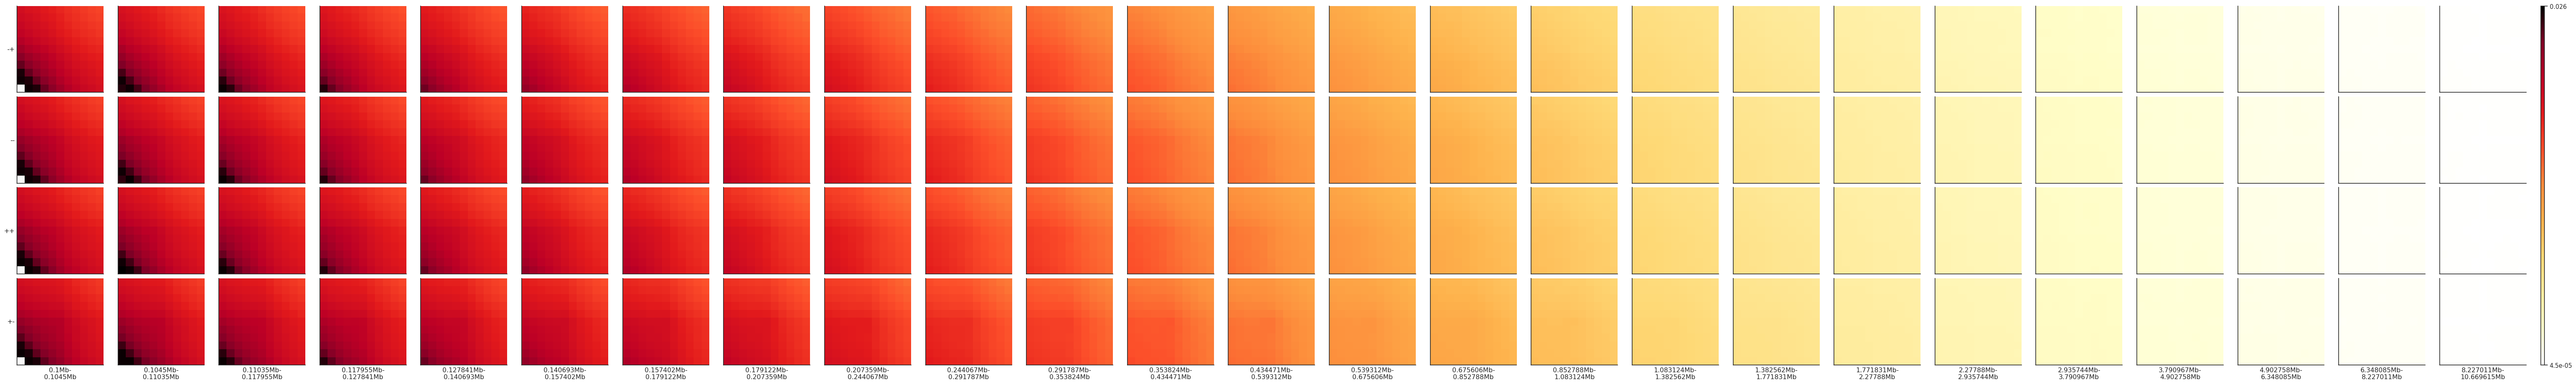

In [40]:
sites=peaks_motifs.copy()


print(band_edge_list)

sample_dict = ['WT']
for sample in sample_dict:
    f=open('dots_vs_distance_peaks_motifs_%s_Bonev.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    clr =  bonev_cooler
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df_bonev[:19],
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=10_000_000,
                        flank=50_000, min_diag=2,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))#/1000
        #print(pseudocount)
        #pseudocount = 10./clr.info['sum']
        #print(pseudocount)
        score=peak_score(pup['data'][i],3,4,pseudocount)
        #print(score)
        if pup['separation'][i]=='all':
            continue
        
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

In [ ]:
# Liu et al 

[100000.0, 104500.0, 110350.0, 117955.0, 127841.5, 140693.95, 157402.135, 179122.77550000005, 207359.60815000004, 244067.49059500004, 291787.7377735001, 353824.05910555006, 434471.2768372151, 539312.6598883797, 675606.4578548936, 852788.3952113617, 1083124.9137747702, 1382562.3879072014, 1771831.104279362, 2277880.4355631704, 2935744.566232122, 3790967.9361017584, 4902758.316932286, 6348085.812011973, 8227011.555615564, 10669615.022300234, 13844999.528990304, 17972999.387687396, 23339399.203993615, 30315718.965191703, 39384934.654749215, 51174915.05117398, 66501889.566526175, 86426956.43648404]


INFO:coolpuppy:('chr18', 'chr18'): 9687
INFO:coolpuppy:('chr16', 'chr16'): 13623
INFO:coolpuppy:('chr13', 'chr13'): 15499
INFO:coolpuppy:('chr3', 'chr3'): 16991
INFO:coolpuppy:('chr14', 'chr14'): 20703
INFO:coolpuppy:('chr12', 'chr12'): 19842
INFO:coolpuppy:('chr19', 'chr19'): 24170
INFO:coolpuppy:('chr1', 'chr1'): 24058
INFO:coolpuppy:('chr10', 'chr10'): 34539
INFO:coolpuppy:('chr15', 'chr15'): 38965
INFO:coolpuppy:('chr17', 'chr17'): 44799
INFO:coolpuppy:('chr2', 'chr2'): 69298
INFO:coolpuppy:('chr4', 'chr4'): 84362
INFO:coolpuppy:('chr11', 'chr11'): 96073
INFO:coolpuppy:Total number of piled up windows: 512609


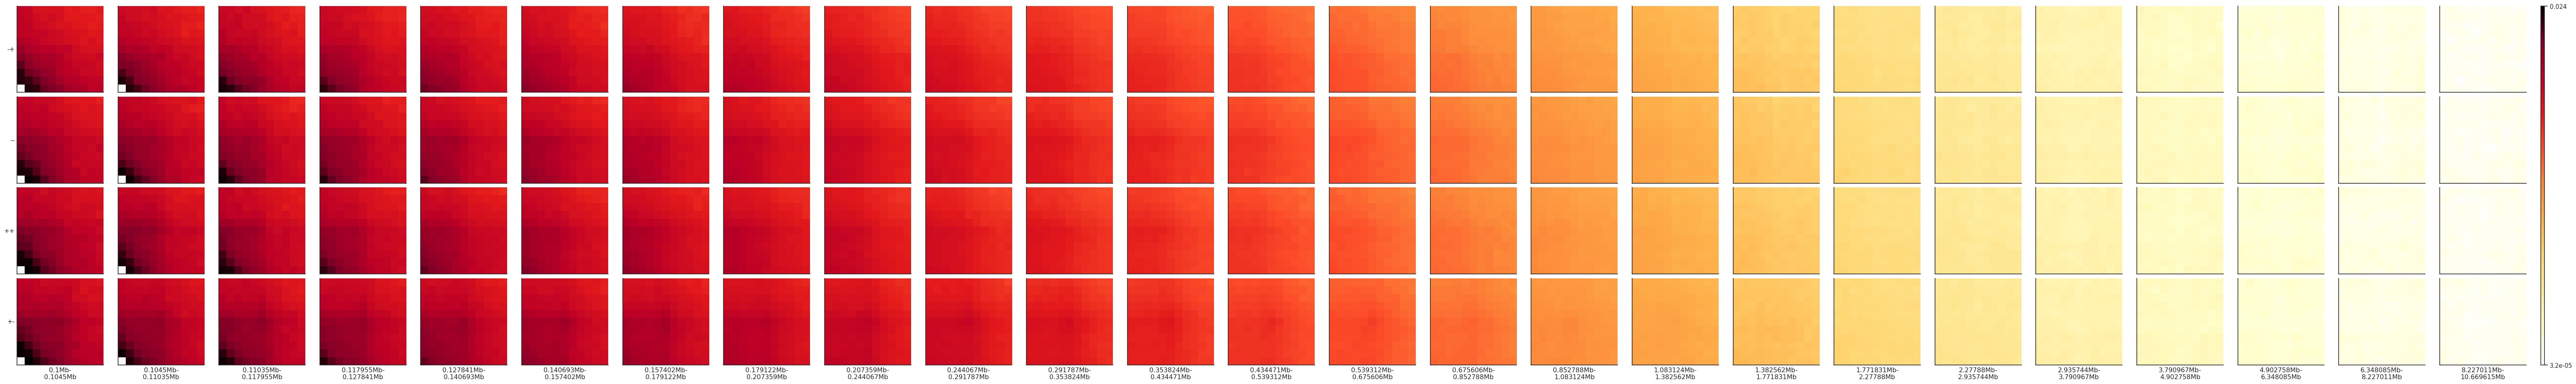

INFO:coolpuppy:('chr18', 'chr18'): 9687
INFO:coolpuppy:('chr16', 'chr16'): 13623
INFO:coolpuppy:('chr13', 'chr13'): 15499
INFO:coolpuppy:('chr3', 'chr3'): 16991
INFO:coolpuppy:('chr12', 'chr12'): 19842
INFO:coolpuppy:('chr14', 'chr14'): 20703
INFO:coolpuppy:('chr19', 'chr19'): 24170
INFO:coolpuppy:('chr1', 'chr1'): 24058
INFO:coolpuppy:('chr10', 'chr10'): 34539
INFO:coolpuppy:('chr15', 'chr15'): 38965
INFO:coolpuppy:('chr17', 'chr17'): 44799
INFO:coolpuppy:('chr2', 'chr2'): 69298
INFO:coolpuppy:('chr4', 'chr4'): 84362
INFO:coolpuppy:('chr11', 'chr11'): 96073
INFO:coolpuppy:Total number of piled up windows: 512609


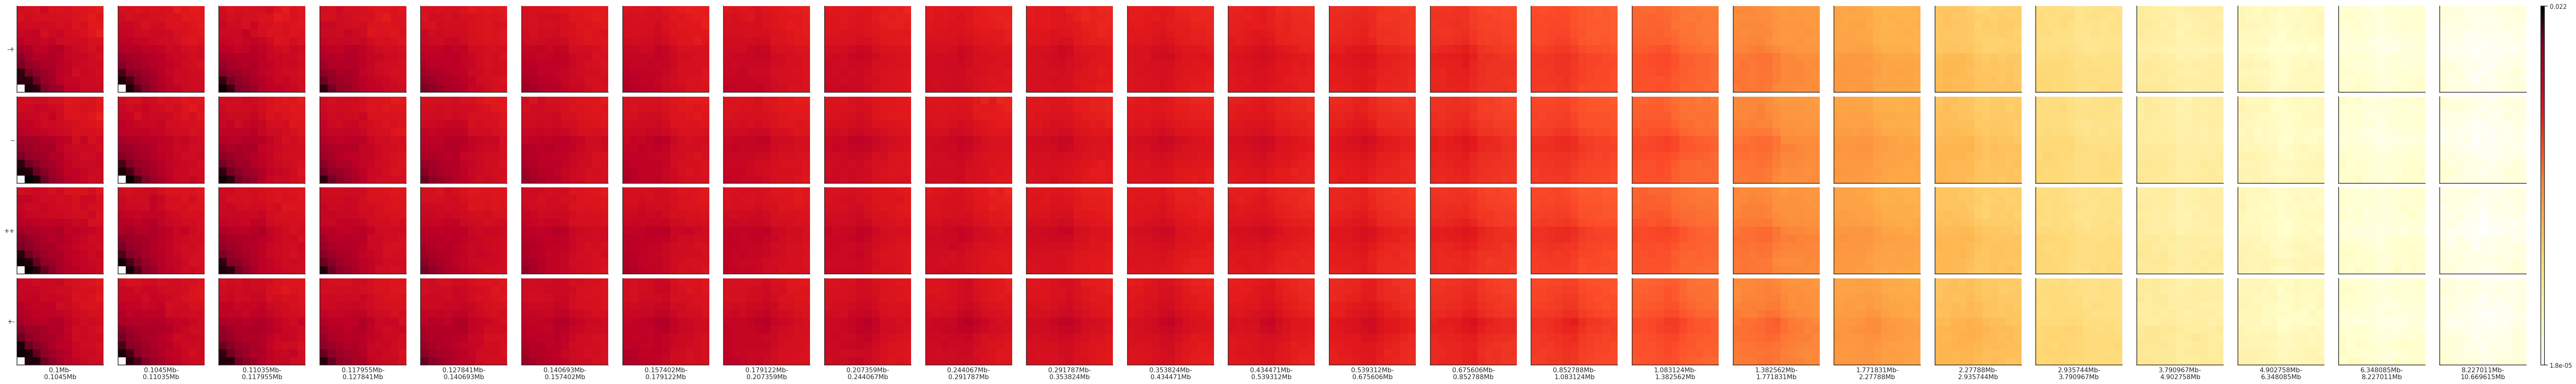

In [88]:
sites=peaks_motifs_quartile.copy()


print(band_edge_list)

for sample in sample_dict_liu:
    f=open('dots_vs_distance_peaks_motifs_%s_Liu_quartile.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    #mcool_path =  cooler_prefix + sample_dict[sample]
    #print(sample,sample_dict[sample],mcool_path)
    mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
    liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
    view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]
    clr =  liu_cooler
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df_liu[:19],
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=10_000_000,
                        flank=50_000, min_diag=2,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))/1000
#        #print(pseudocount)
#        #pseudocount = 10./clr.info['sum']
        #print(pseudocount)
        #pseudocount = np.nanmean(pup['data'][i])
        score=peak_score(pup['data'][i],3,4,pseudocount)
        #print(score)
        if pup['separation'][i]=='all':
            continue
#        
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

In [105]:
region = 'chr1:4000000-100000000'
#region = 'chr1:1000000-4500000'
#region = 'chr1:40000000-41000000'
#mcool_path =  cooler_prefix + sample_dict['Wapl-6h']
#clr = cooler.Cooler(mcool_path+'::resolutions/'+str(res))
#region_start=bioframe.parse_region_string(region)[1]

#cname = (cooler.Cooler(mcool_path+'::resolutions/'+str(res)).matrix(balance=True).fetch(region))
#print(cname)
#mat = (cooler.Cooler(mcool_path+'::resolutions/'+str(res)).matrix(balance=True).fetch(region))
cname = ((clr).matrix(balance=True).fetch(region))
print(np.nanmean(cname))

9.673689007897251e-05


[100000.0, 104500.0, 110350.0, 117955.0, 127841.5, 140693.95, 157402.135, 179122.77550000005, 207359.60815000004, 244067.49059500004, 291787.7377735001, 353824.05910555006, 434471.2768372151, 539312.6598883797, 675606.4578548936, 852788.3952113617, 1083124.9137747702, 1382562.3879072014, 1771831.104279362, 2277880.4355631704, 2935744.566232122, 3790967.9361017584, 4902758.316932286, 6348085.812011973, 8227011.555615564, 10669615.022300234, 13844999.528990304, 17972999.387687396, 23339399.203993615, 30315718.965191703, 39384934.654749215, 51174915.05117398, 66501889.566526175, 86426956.43648404]


INFO:coolpuppy:('chr18', 'chr18'): 300134
INFO:coolpuppy:('chr16', 'chr16'): 344691
INFO:coolpuppy:('chr14', 'chr14'): 386063
INFO:coolpuppy:('chr12', 'chr12'): 396090
INFO:coolpuppy:('chr19', 'chr19'): 423475
INFO:coolpuppy:('chr13', 'chr13'): 431120
INFO:coolpuppy:('chr3', 'chr3'): 427261
INFO:coolpuppy:('chr15', 'chr15'): 681094
INFO:coolpuppy:('chr10', 'chr10'): 641419
INFO:coolpuppy:('chr1', 'chr1'): 661241
INFO:coolpuppy:('chr17', 'chr17'): 786116
INFO:coolpuppy:('chr2', 'chr2'): 1173608
INFO:coolpuppy:('chr4', 'chr4'): 1263165
INFO:coolpuppy:('chr11', 'chr11'): 1660385
INFO:coolpuppy:Total number of piled up windows: 9575862


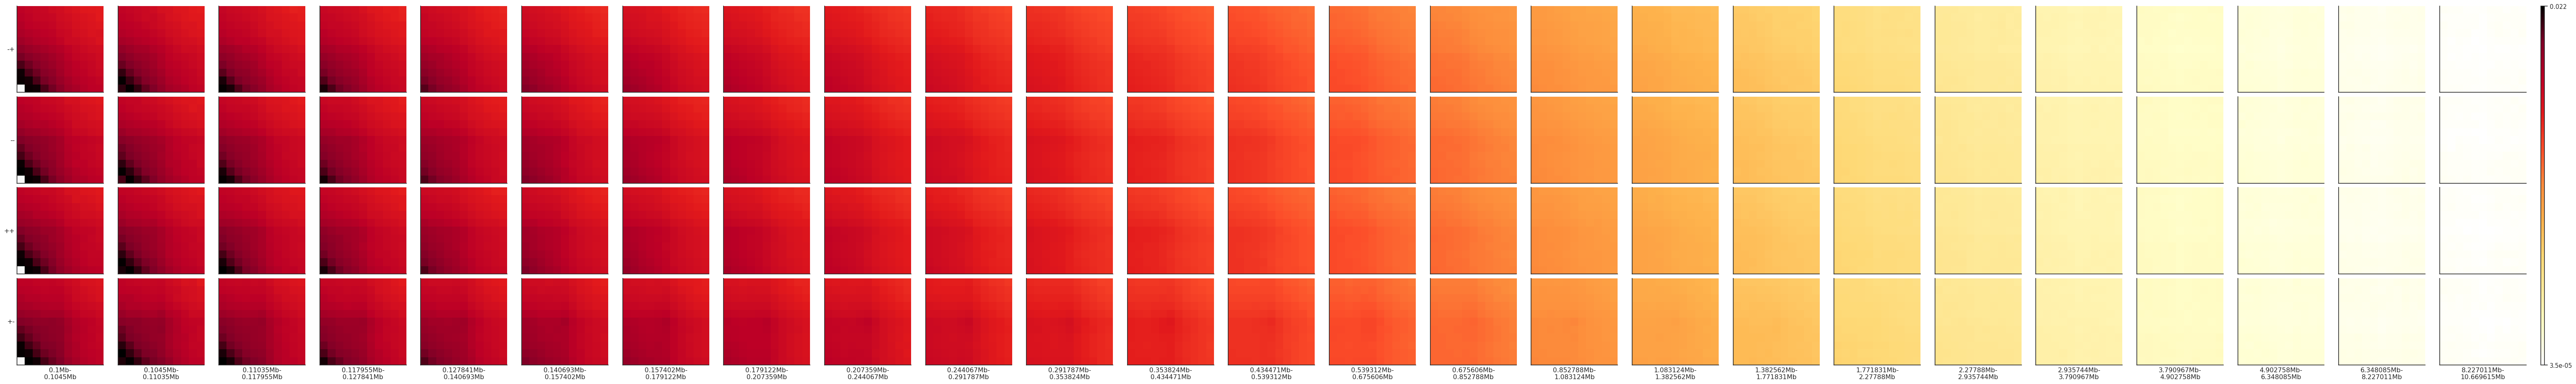

INFO:coolpuppy:('chr18', 'chr18'): 300134
INFO:coolpuppy:('chr16', 'chr16'): 344691
INFO:coolpuppy:('chr12', 'chr12'): 396090
INFO:coolpuppy:('chr14', 'chr14'): 386063
INFO:coolpuppy:('chr19', 'chr19'): 423475
INFO:coolpuppy:('chr13', 'chr13'): 431120
INFO:coolpuppy:('chr3', 'chr3'): 427261
INFO:coolpuppy:('chr10', 'chr10'): 641419
INFO:coolpuppy:('chr1', 'chr1'): 661241
INFO:coolpuppy:('chr15', 'chr15'): 681094
INFO:coolpuppy:('chr17', 'chr17'): 786116
INFO:coolpuppy:('chr4', 'chr4'): 1263165
INFO:coolpuppy:('chr2', 'chr2'): 1173608
INFO:coolpuppy:('chr11', 'chr11'): 1660385
INFO:coolpuppy:Total number of piled up windows: 9575862


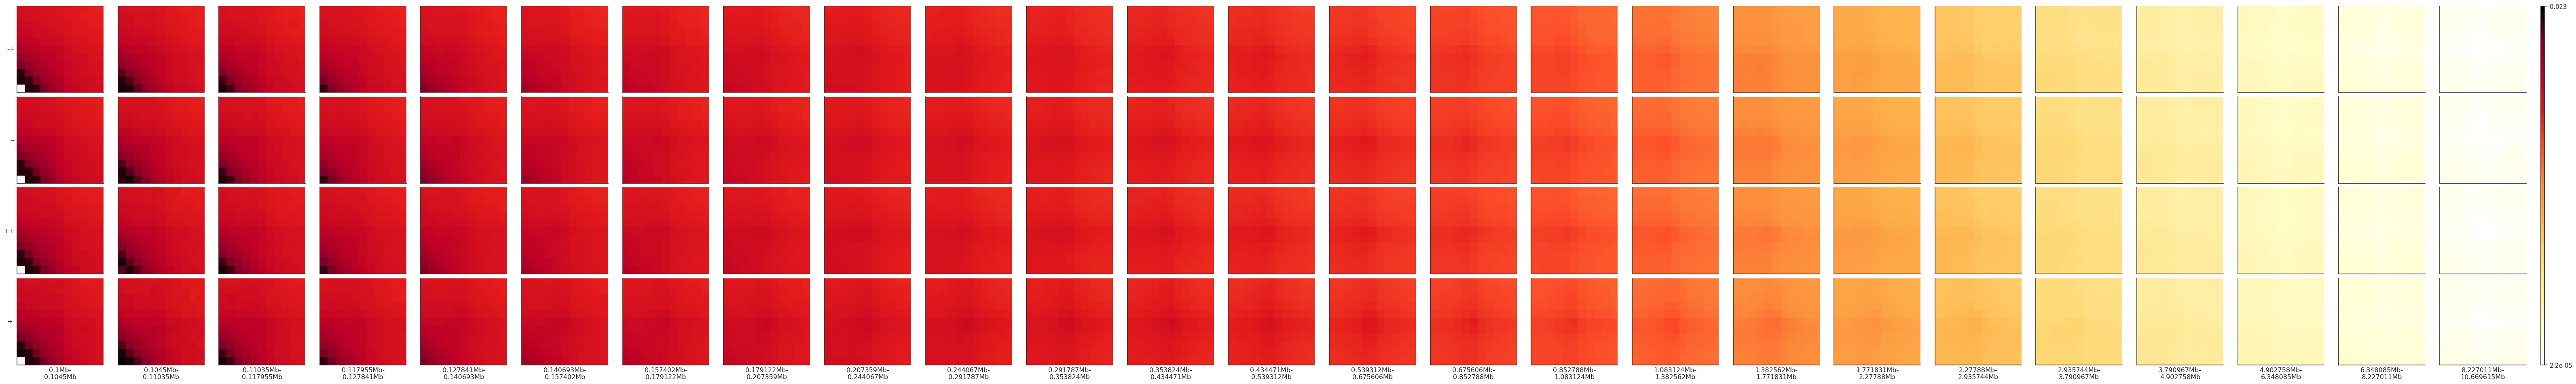

In [42]:
sites=peaks_motifs.copy()

#beginning = 105_000
#mindist = 95_000
#band_edges = np.append([beginning], 95_000 + 10_000 * 1.3 ** np.arange(1,34))
#band_edge_list=list(band_edges[:])
#pseudocount = 10./clr.info['sum']
print(band_edge_list)

for sample in sample_dict_liu:
    f=open('dots_vs_distance_peaks_motifs_%s_Liu.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    #mcool_path =  cooler_prefix + sample_dict[sample]
    #print(sample,sample_dict[sample],mcool_path)
    mcool_path_liu =  cooler_prefix_liu + sample_dict_liu[sample]
    liu_cooler = cooler.Cooler(mcool_path_liu+'::resolutions/'+str(res))
    view_df_liu = cooltools.lib.make_cooler_view(liu_cooler)[:19]
    clr =  liu_cooler
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df_liu[:19],
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=10_000_000,
                        flank=50_000, min_diag=2,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))#/1000
        #print(pseudocount)
        #pseudocount = 10./clr.info['sum']
        #print(pseudocount)
        score=peak_score(pup['data'][i],3,4,pseudocount)
        #print(score)
        if pup['separation'][i]=='all':
            continue
        
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

In [43]:
# Liu et al 2021

[90000.0, 105000.0, 112500.0, 123750.0, 140625.0, 165937.5, 203906.25, 260859.375, 346289.0625, 474433.59375, 666650.390625, 954975.5859375, 1387463.37890625, 2036195.068359375, 3009292.6025390625, 4468938.903808594, 6658408.355712891, 9942612.533569336, 14868918.800354004]


INFO:coolpuppy:('chr18', 'chr18'): 9687
INFO:coolpuppy:('chr13', 'chr13'): 15499
INFO:coolpuppy:('chr16', 'chr16'): 13623
INFO:coolpuppy:('chr3', 'chr3'): 16991
INFO:coolpuppy:('chr14', 'chr14'): 20703
INFO:coolpuppy:('chr19', 'chr19'): 24170
INFO:coolpuppy:('chr12', 'chr12'): 19842
INFO:coolpuppy:('chr1', 'chr1'): 24058
INFO:coolpuppy:('chr10', 'chr10'): 34539
INFO:coolpuppy:('chr6', 'chr6'): 38481
INFO:coolpuppy:('chr15', 'chr15'): 38965
INFO:coolpuppy:('chr9', 'chr9'): 37833
INFO:coolpuppy:('chr17', 'chr17'): 44799
INFO:coolpuppy:('chr8', 'chr8'): 50603
INFO:coolpuppy:('chr7', 'chr7'): 61416
INFO:coolpuppy:('chr2', 'chr2'): 69298
INFO:coolpuppy:('chr4', 'chr4'): 84362
INFO:coolpuppy:('chr11', 'chr11'): 96073
INFO:coolpuppy:('chr5', 'chr5'): 124503
INFO:coolpuppy:Total number of piled up windows: 825445


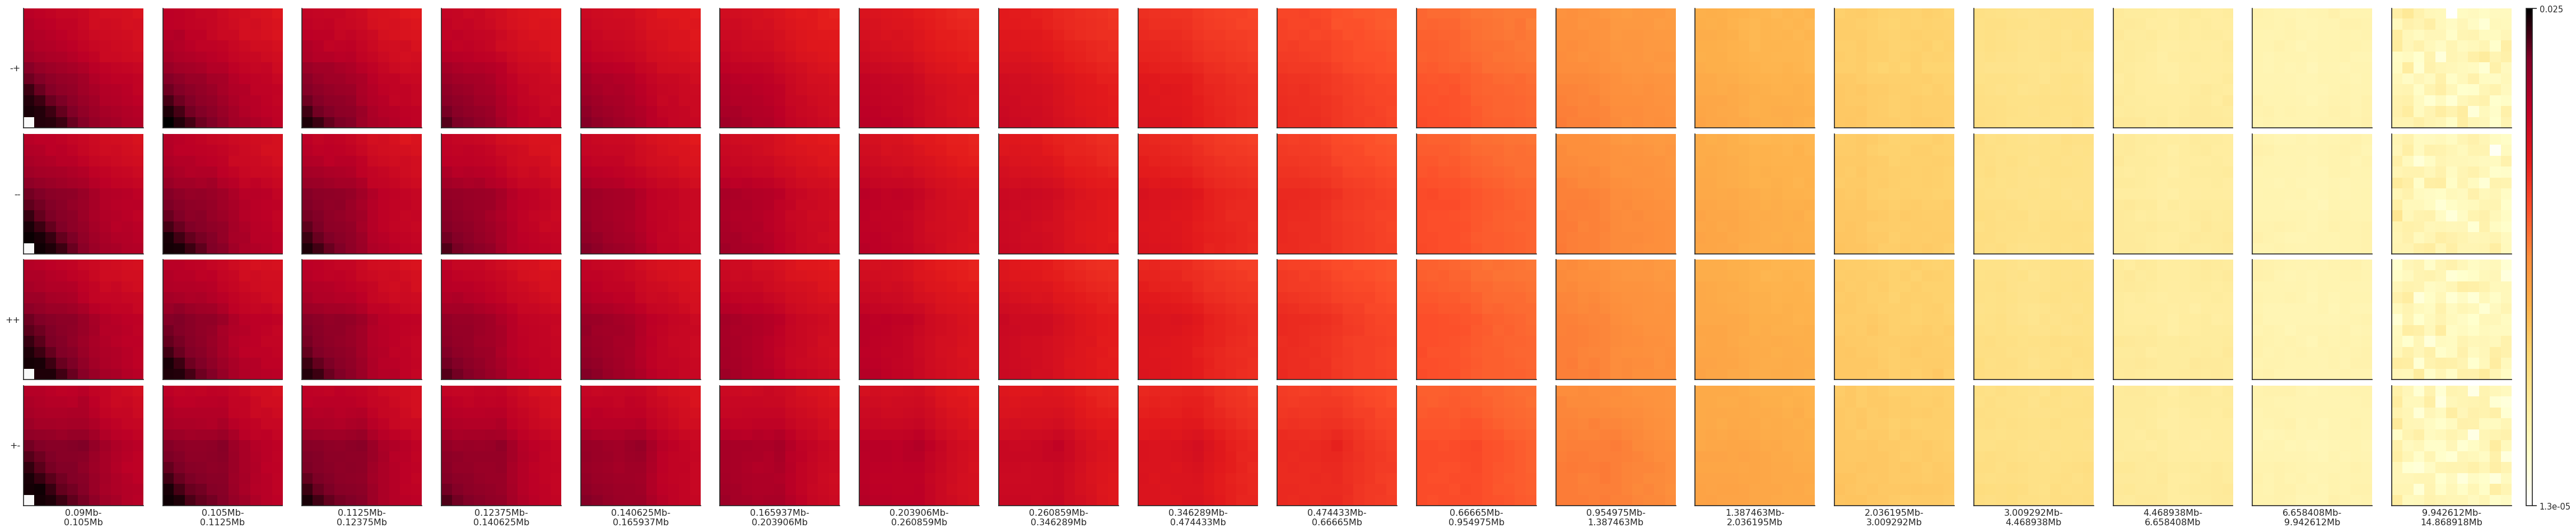

INFO:coolpuppy:('chr18', 'chr18'): 9687
INFO:coolpuppy:('chr16', 'chr16'): 13623
INFO:coolpuppy:('chr13', 'chr13'): 15499
INFO:coolpuppy:('chr3', 'chr3'): 16991
INFO:coolpuppy:('chr12', 'chr12'): 19842
INFO:coolpuppy:('chr14', 'chr14'): 20703
INFO:coolpuppy:('chr19', 'chr19'): 24170
INFO:coolpuppy:('chr1', 'chr1'): 24058
INFO:coolpuppy:('chr10', 'chr10'): 34539
INFO:coolpuppy:('chr15', 'chr15'): 38965
INFO:coolpuppy:('chr9', 'chr9'): 37833
INFO:coolpuppy:('chr6', 'chr6'): 38481
INFO:coolpuppy:('chr17', 'chr17'): 44799
INFO:coolpuppy:('chr8', 'chr8'): 50603
INFO:coolpuppy:('chr7', 'chr7'): 61416
INFO:coolpuppy:('chr2', 'chr2'): 69298
INFO:coolpuppy:('chr4', 'chr4'): 84362
INFO:coolpuppy:('chr11', 'chr11'): 96073
INFO:coolpuppy:('chr5', 'chr5'): 124503
INFO:coolpuppy:Total number of piled up windows: 825445


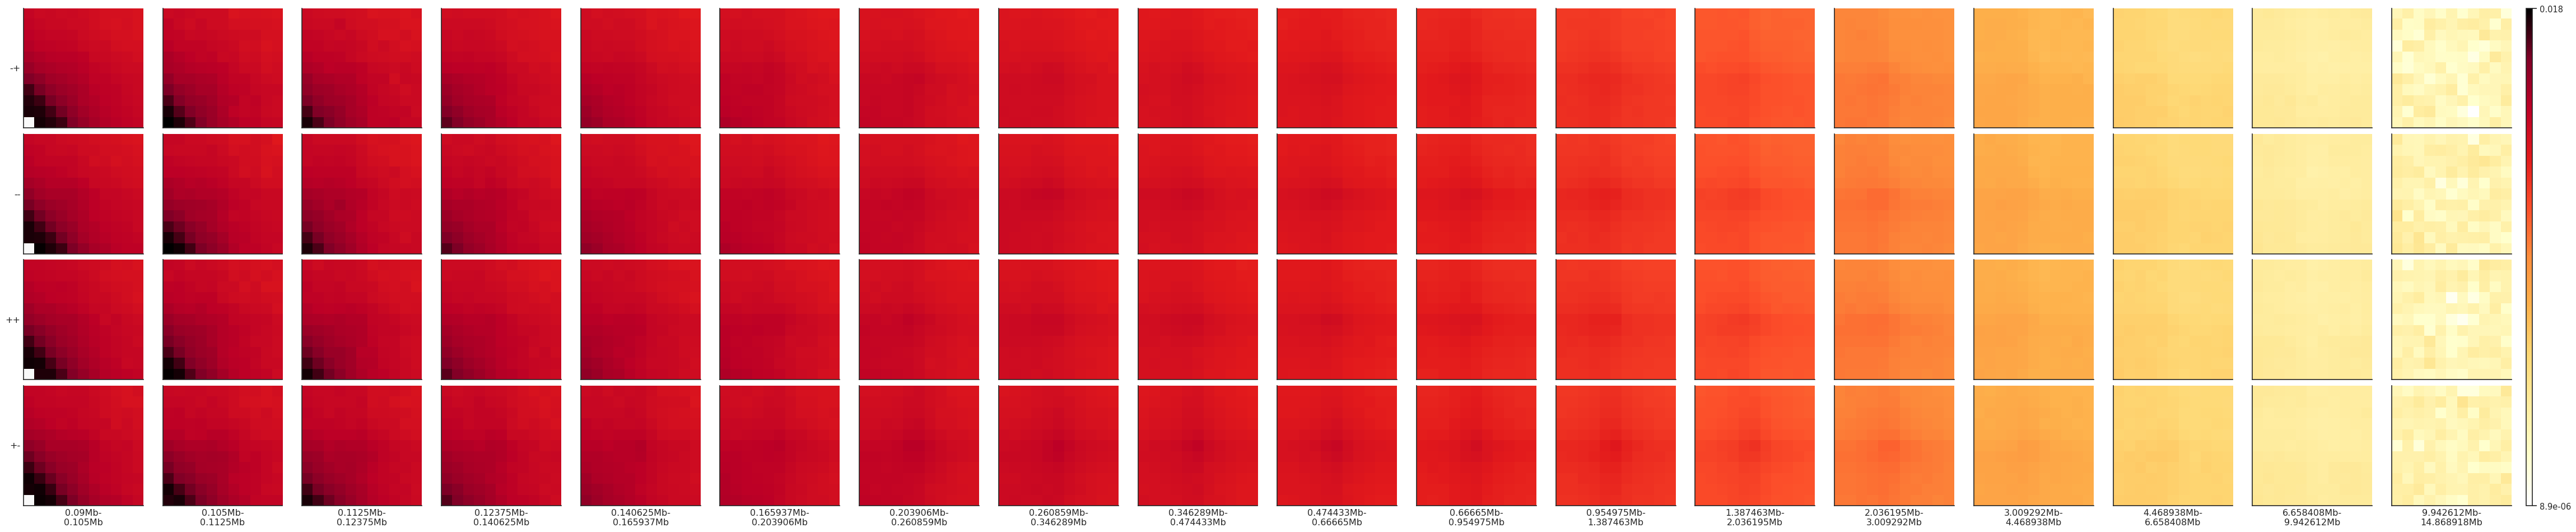

In [95]:
sites=peaks_motifs_quartile.copy()

#beginning = 105_000
#mindist = 95_000
#band_edges = np.append([beginning], 95_000 + 10_000 * 1.3 ** np.arange(1,34))
#band_edge_list=list(band_edges[:])
#pseudocount = 10./clr.info['sum']
print(band_edge_list)

for sample in sample_dict_liu_new:
    f=open('dots_vs_distance_peaks_motifs_%s_Liu_new_quartile.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    #mcool_path =  cooler_prefix + sample_dict[sample]
    #print(sample,sample_dict[sample],mcool_path)
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    clr =  liu_cooler_new
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df_liu_new[:19],
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=10_000_000,
                        flank=50_000, min_diag=2,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))/1000
#        #print(pseudocount)
#        #pseudocount = 10./clr.info['sum']
        #print(pseudocount)
        score=peak_score(pup['data'][i],3,4,pseudocount)
        #print(score)
        if pup['separation'][i]=='all':
            continue
#        
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

[100000.0, 104500.0, 110350.0, 117955.0, 127841.5, 140693.95, 157402.135, 179122.77550000005, 207359.60815000004, 244067.49059500004, 291787.7377735001, 353824.05910555006, 434471.2768372151, 539312.6598883797, 675606.4578548936, 852788.3952113617, 1083124.9137747702, 1382562.3879072014, 1771831.104279362, 2277880.4355631704, 2935744.566232122, 3790967.9361017584, 4902758.316932286, 6348085.812011973, 8227011.555615564, 10669615.022300234, 13844999.528990304, 17972999.387687396, 23339399.203993615, 30315718.965191703, 39384934.654749215, 51174915.05117398, 66501889.566526175, 86426956.43648404]


INFO:coolpuppy:('chr18', 'chr18'): 300134
INFO:coolpuppy:('chr16', 'chr16'): 344691
INFO:coolpuppy:('chr14', 'chr14'): 386063
INFO:coolpuppy:('chr12', 'chr12'): 396090
INFO:coolpuppy:('chr19', 'chr19'): 423475
INFO:coolpuppy:('chr13', 'chr13'): 431120
INFO:coolpuppy:('chr3', 'chr3'): 427261
INFO:coolpuppy:('chr15', 'chr15'): 681094
INFO:coolpuppy:('chr10', 'chr10'): 641419
INFO:coolpuppy:('chr1', 'chr1'): 661241
INFO:coolpuppy:('chr17', 'chr17'): 786116
INFO:coolpuppy:('chr8', 'chr8'): 803319
INFO:coolpuppy:('chr6', 'chr6'): 789464
INFO:coolpuppy:('chr9', 'chr9'): 867736
INFO:coolpuppy:('chr7', 'chr7'): 1049751
INFO:coolpuppy:('chr2', 'chr2'): 1173608
INFO:coolpuppy:('chr4', 'chr4'): 1263165
INFO:coolpuppy:('chr11', 'chr11'): 1660385
INFO:coolpuppy:('chr5', 'chr5'): 1903307
INFO:coolpuppy:Total number of piled up windows: 14989439


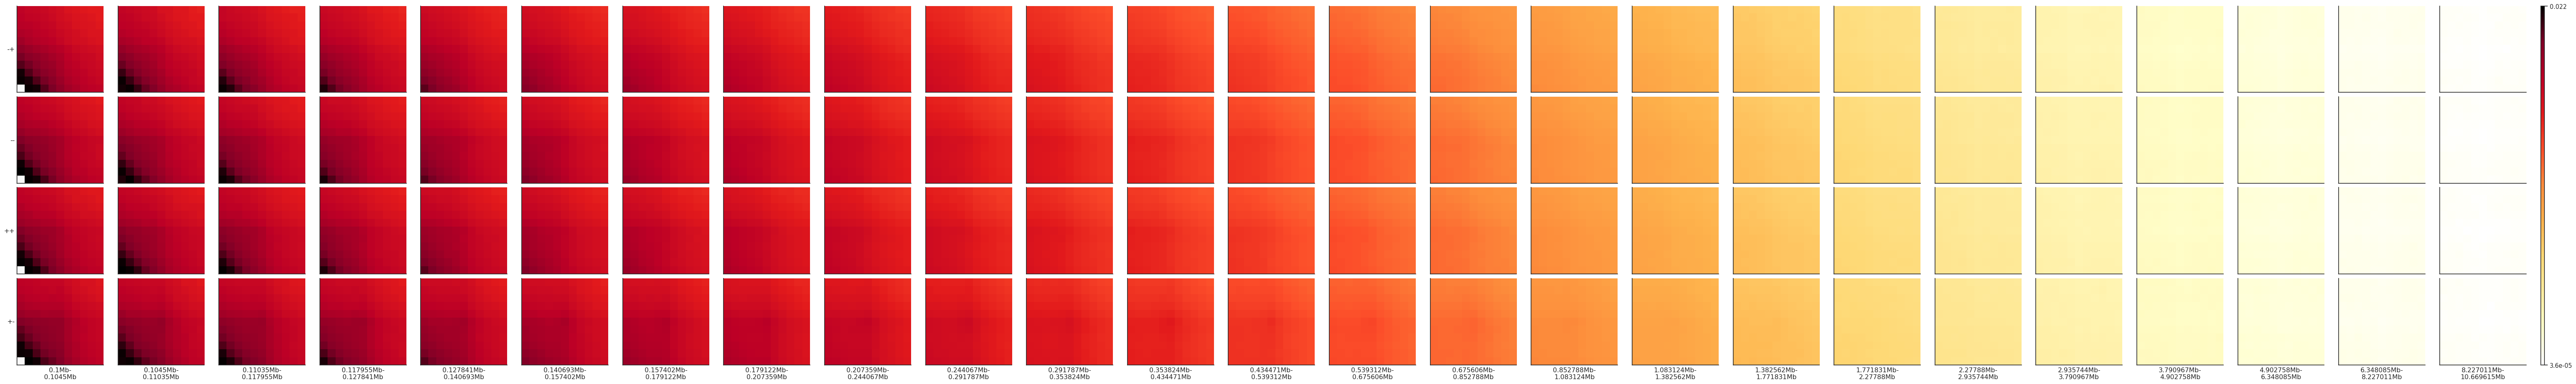

INFO:coolpuppy:('chr18', 'chr18'): 300134
INFO:coolpuppy:('chr16', 'chr16'): 344691
INFO:coolpuppy:('chr14', 'chr14'): 386063
INFO:coolpuppy:('chr12', 'chr12'): 396090
INFO:coolpuppy:('chr19', 'chr19'): 423475
INFO:coolpuppy:('chr3', 'chr3'): 427261
INFO:coolpuppy:('chr13', 'chr13'): 431120
INFO:coolpuppy:('chr10', 'chr10'): 641419
INFO:coolpuppy:('chr15', 'chr15'): 681094
INFO:coolpuppy:('chr1', 'chr1'): 661241
INFO:coolpuppy:('chr17', 'chr17'): 786116
INFO:coolpuppy:('chr6', 'chr6'): 789464
INFO:coolpuppy:('chr8', 'chr8'): 803319
INFO:coolpuppy:('chr9', 'chr9'): 867736
INFO:coolpuppy:('chr7', 'chr7'): 1049751
INFO:coolpuppy:('chr2', 'chr2'): 1173608
INFO:coolpuppy:('chr4', 'chr4'): 1263165
INFO:coolpuppy:('chr11', 'chr11'): 1660385
INFO:coolpuppy:('chr5', 'chr5'): 1903307
INFO:coolpuppy:Total number of piled up windows: 14989439


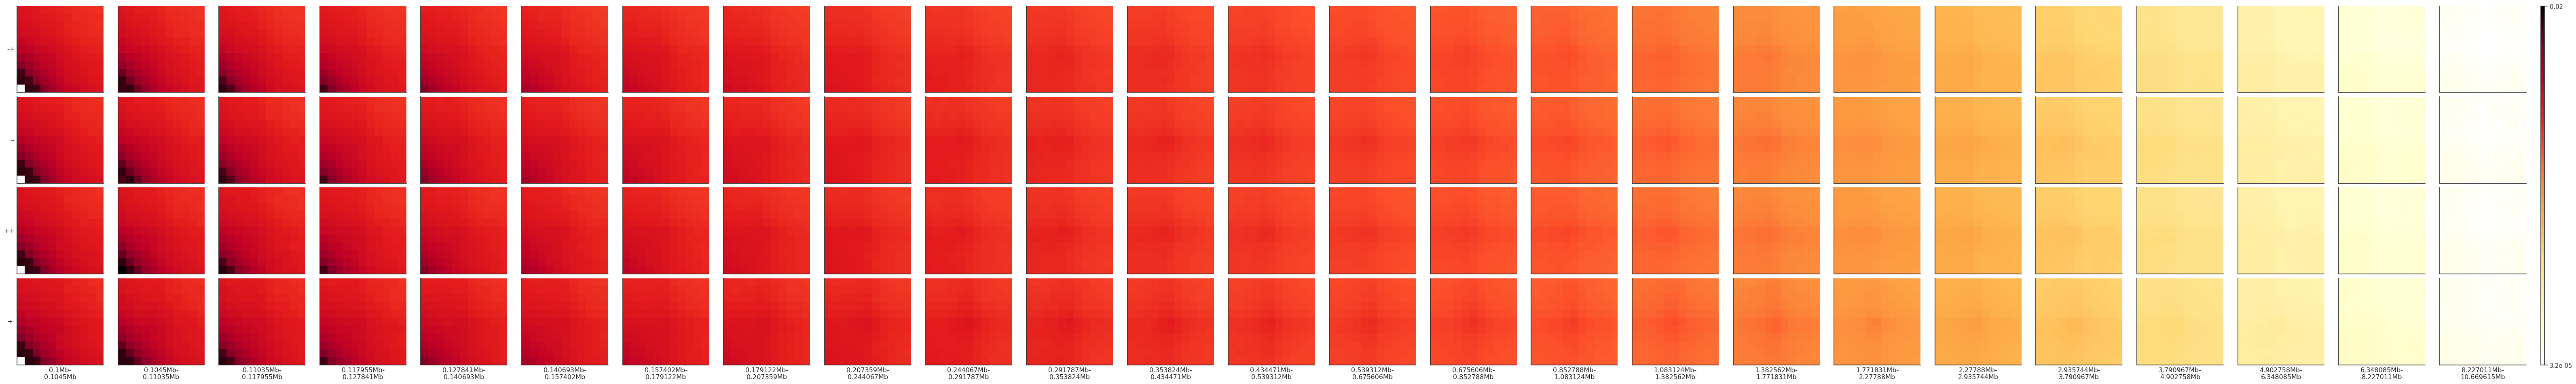

In [45]:
sites=peaks_motifs.copy()

print(band_edge_list)

for sample in sample_dict_liu_new:
    f=open('dots_vs_distance_peaks_motifs_%s_Liu_quartile.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    mcool_path_liu_new =  cooler_prefix_liu_new + sample_dict_liu_new[sample]
    liu_cooler_new = cooler.Cooler(mcool_path_liu_new+'::resolutions/'+str(res))
    view_df_liu_new = cooltools.lib.make_cooler_view(liu_cooler_new)[:19]
    clr =  liu_cooler_new
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df_liu_new[:19],
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=10_000_000,
                        flank=50_000, min_diag=2,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))#/1000
#        #print(pseudocount)
#        #pseudocount = 10./clr.info['sum']
        #print(pseudocount)
        score=peak_score(pup['data'][i],3,4,pseudocount)
        if pup['separation'][i]=='all':
            continue
       
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

### peak score vs distance

In [36]:
import matplotlib.pylab as plt

import scipy

import numpy as np

import pandas as pd

from scipy.ndimage import gaussian_filter1d
def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)

In [45]:
# Liu et al

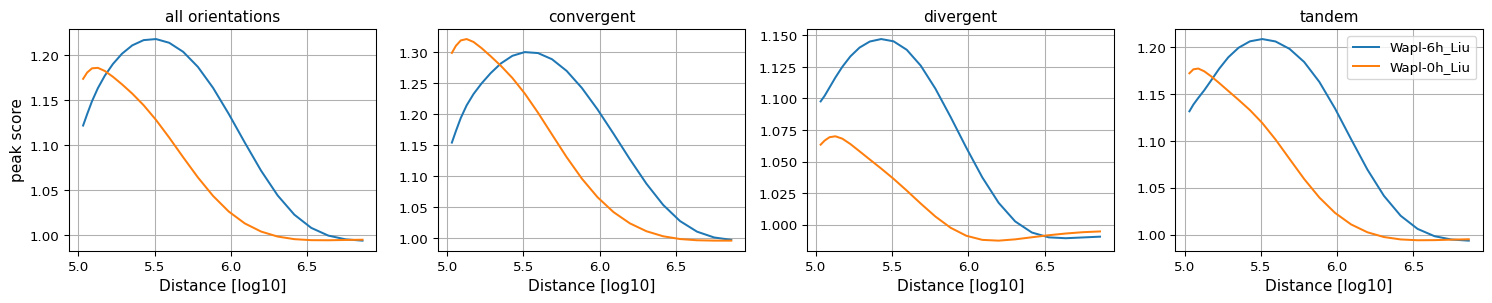

In [91]:
fig, axs = plt.subplots(1, 4, figsize=(19, 3))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu']#,'WT_Bonev', 'Wapl-0h_new_Liu_','Wapl-24h_new_Liu_']


def smooth(x, sigma = 1.93):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('dots_vs_distance_peaks_motifs_%s_quartile.csv'%name)
    data = data[data['dist']<=7500000]
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    pixel_start = 1
    axs[1].plot(np.log10(dist_conv)[pixel_start:],smooth(score_conv)[pixel_start:],label='%s'%name)
    axs[0].plot(np.log10(dist_conv)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
    axs[2].plot(np.log10(dist_conv)[pixel_start:],smooth(score_dive)[pixel_start:],label='%s'%name)
    axs[3].plot(np.log10(dist_conv)[pixel_start:], smooth(score_tandemp)[pixel_start:], label='%s'%name)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
axs[1].set_title('convergent', fontsize = 11.5)
axs[2].set_title('divergent', fontsize = 11.5)
axs[3].set_title('tandem', fontsize = 11.5)
axs[0].set_title('all orientations', fontsize = 11.5)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance [log10]', fontsize = 11.5)
    #ax.set_ylim(0.95,1.35)
axs[3].legend( bbox_to_anchor=(1.0005, 0.87),loc='right')
axs[0].set_ylabel('peak score',fontsize = 11.5)

#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('../images/observed_for_ctcf&motifs_from_papers.pdf', bbox_inches = 'tight')
plt.show()

Wapl-6h_Liu 1.1267534318756678
Wapl-0h_Liu 1.0904139050817985


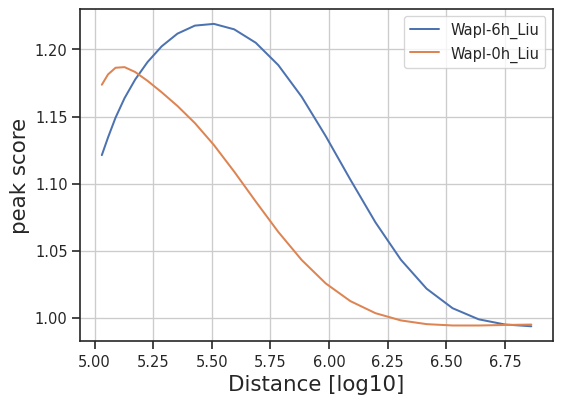

In [111]:
fig, axs = plt.subplots(1, 1, figsize=(6.35, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu',]


def smooth(x, sigma = 1.85):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('dots_vs_distance_peaks_motifs_%s_quartile.csv'%name)
    data=data[data['dist']<=7500000]
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    #print(data)
    #print(dist_conv)
    print(name,np.mean(score_ave))
    axs.plot(np.log10(dist_conv)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
#axs.set_ylim(0.9, 1.195)
#plt.ylabel('Peak score',fontsize = 11.5)
#plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
#axs.set_title('all orientations', fontsize = 11.5)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 16)
#ax.set_ylim(0.95,1.35)
#axs.legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs.legend(fontsize=11)
axs.set_ylabel('peak score',fontsize = 16)
axs.tick_params(labelsize=11)
axs.tick_params(labelsize=11)
#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
#plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('../images/observed_for_ctcf&motifs_from_papers_top_quart_ave.pdf', transparent=True, bbox_inches = 'tight')
plt.show()

Wapl-6h_Liu 1.1267534318756678
Wapl-0h_Liu 1.0904139050817985


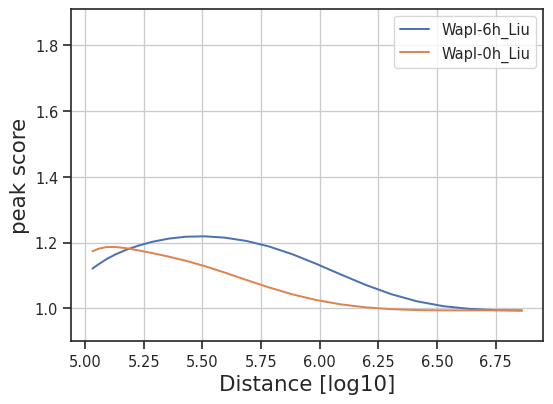

In [112]:
fig, axs = plt.subplots(1, 1, figsize=(6.35, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu',]


def smooth(x, sigma = 1.85):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('dots_vs_distance_peaks_motifs_%s_quartile.csv'%name)
    data=data[data['dist']<=7500000]
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    #print(data)
    #print(dist_conv)
    print(name,np.mean(score_ave))
    axs.plot(np.log10(dist_conv)[pixel_start:],smooth(score_ave)[pixel_start:],label='%s'%name)
#axs.set_ylim(0.9, 1.195)
#plt.ylabel('Peak score',fontsize = 11.5)
#plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
#axs.set_title('all orientations', fontsize = 11.5)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 16)
axs.set_ylim([0.9,1.91])
#axs.legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs.legend(fontsize=11)
axs.set_ylabel('peak score',fontsize = 16)
axs.tick_params(labelsize=11)
axs.tick_params(labelsize=11)
#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
#plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('../images/observed_for_ctcf&motifs_from_papers_top_quart_ave_magnitude.pdf', transparent=True, bbox_inches = 'tight')
plt.show()

In [96]:
# Liu et al new

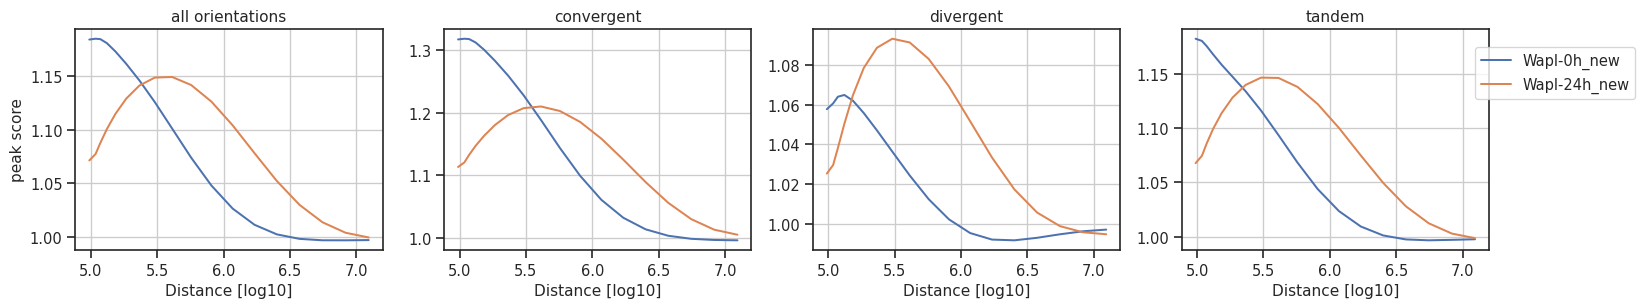

In [101]:
fig, axs = plt.subplots(1, 4, figsize=(19, 3))  # 3 rows, 1 column

new_sample_dict =['Wapl-0h_new','Wapl-24h_new']#,'WT_Bonev', 'Wapl-0h_new_Liu_','Wapl-24h_new_Liu_']

sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}
def smooth(x, sigma = 1.95):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('dots_vs_distance_peaks_motifs_%s_Liu_new_quartile.csv'%name)
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    axs[1].plot(np.log10(dist_conv),smooth(score_conv),label='%s'%name)
    axs[0].plot(np.log10(dist_conv),smooth(score_ave),label='%s'%name)
    axs[2].plot(np.log10(dist_conv),smooth(score_dive),label='%s'%name)
    axs[3].plot(np.log10(dist_conv), smooth(score_tandemp), label='%s'%name)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
axs[1].set_title('convergent', fontsize = 11.5)
axs[2].set_title('divergent', fontsize = 11.5)
axs[3].set_title('tandem', fontsize = 11.5)
axs[0].set_title('all orientations', fontsize = 11.5)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance [log10]', fontsize = 11.5)
    #ax.set_ylim(0.95,1.35)
axs[3].legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs[0].set_ylabel('peak score',fontsize = 11.5)

#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('observed_for_ctcf&motifs_from_papers.png', bbox_inches = 'tight')
plt.show()

### calculating average of peak score

In [107]:
#file = open('../data/peak_score_averaged_hsteps_coolres10.csv','w')

#file.write('life,velocity,clife,cof,peak_ave\n')

for sample in sample_dict_liu:
    print(sample)
    f=pd.read_csv('dots_vs_distance_peaks_motifs_%s_Liu_quartile.csv'%sample)
    #params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    #face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    #if step==400.0: continue
    #f =pd.read_csv('../data/peakscore/peakscore_%s_hsteps_cool_res10.csv' % name)
    #print(f)
    f=f[f['dist']<=6337208.5]
    chr_dist = f['dist']
    peak_scores = f['peak_score']
    
    #plt.plot((chr_dist*1000), smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s'%(clife,cof))
    #plot_curve_and_auc((chr_dist*1000), smooth(peak_score))
    #area = calculate_auc((chr_dist), smooth(peak_score))/1000
    peak_ave = np.mean(peak_scores)
    print(peak_ave)
    #print('area under the curve is',area)
    #file.write('%s,%s,%s,%s,%s\n'%(life, vel, clife,cof, peak_ave))

#file.close()

Wapl-0h
1.0945089475595204
Wapl-6h
1.1325287279548484


In [105]:
#file = open('../data/peak_score_averaged_hsteps_coolres10.csv','w')

#file.write('life,velocity,clife,cof,peak_ave\n')
sample_dict_liu_new ={
    'Wapl-0h_new':'liu_wapl0h.mm10.mapq_30.1000.mcool',
    'Wapl-24h_new':'liu_wapl24h.mm10.mapq_30.1000.mcool'
}
for sample in sample_dict_liu_new:
    print(sample)
    f=pd.read_csv('dots_vs_distance_peaks_motifs_%s_Liu_new_quartile.csv'%sample)
    #params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    #face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    #if step==400.0: continue
    #f =pd.read_csv('../data/peakscore/peakscore_%s_hsteps_cool_res10.csv' % name)
    #print(f)
    f=f[f['dist']<=6337208.5]
    chr_dist = f['dist']
    peak_score = f['peak_score']
    
    #plt.plot((chr_dist*1000), smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s'%(clife,cof))
    #plot_curve_and_auc((chr_dist*1000), smooth(peak_score))
    #area = calculate_auc((chr_dist), smooth(peak_score))/1000
    peak_ave = np.mean(peak_score)
    print(peak_ave)
    #print('area under the curve is',area)
    #file.write('%s,%s,%s,%s,%s\n'%(life, vel, clife,cof, peak_ave))

#file.close()

Wapl-0h_new
1.099789385758725
Wapl-24h_new
1.0986761801817608


In [106]:
#file = open('../data/peak_score_averaged_hsteps_coolres10.csv','w')

#file.write('life,velocity,clife,cof,peak_ave\n')

for sample in sample_dict_liu_new:
    print(sample)
    f=pd.read_csv('dots_vs_distance_peaks_motifs_%s_Liu_new_quartile.csv'%sample)
    #params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    #face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    #if step==400.0: continue
    #f =pd.read_csv('../data/peakscore/peakscore_%s_hsteps_cool_res10.csv' % name)
    #print(f)
    f=f[f['dist']<=6337208.5]
    chr_dist = f['dist']
    peak_scores = f['peak_score']
    
    #plt.plot((chr_dist*1000), smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s'%(clife,cof))
    #plot_curve_and_auc((chr_dist*1000), smooth(peak_score))
    #area = calculate_auc((chr_dist), smooth(peak_score))/1000
    peak_ave = np.mean(peak_scores)
    print(peak_ave)
    #print('area under the curve is',area)
    #file.write('%s,%s,%s,%s,%s\n'%(life, vel, clife,cof, peak_ave))

#file.close()

Wapl-0h_new
1.099789385758725
Wapl-24h_new
1.0986761801817608


### observed over expected

[105000.0, 108000.0, 111900.0, 116970.0, 123561.0, 132129.3, 143268.09000000003, 157748.51700000002, 176573.07210000002, 201044.99373000005, 232858.49184900004, 274216.03940370004, 327980.8512248101, 397875.10659225314, 488737.6385699291, 606858.9301409079, 760416.6091831801, 960041.5919381344, 1219554.0695195745, 1556920.290375447, 1995496.3774880813, 2565645.2907345057, 3306838.8779548574, 4270390.541341315, 5523007.703743709, 7151410.014866822, 9268333.01932687, 12020332.92512493, 15597932.80266241, 20248812.643461134, 26294956.43649948, 34154943.36744932, 44372926.37768412, 57656304.290989354]
Wapl-0h_new liu_wapl0h.mm10.mapq_30.1000.mcool /project/fudenber_735/GEO/liu_deWit_2021_GSE135180/distiller-mm10/results/coolers_library/liu_wapl0h.mm10.mapq_30.1000.mcool


INFO:coolpuppy:('chr18', 'chr18'): 9683
INFO:coolpuppy:('chr16', 'chr16'): 13613
INFO:coolpuppy:('chr13', 'chr13'): 15480
INFO:coolpuppy:('chr12', 'chr12'): 19828
INFO:coolpuppy:('chr3', 'chr3'): 16970
INFO:coolpuppy:('chr19', 'chr19'): 24133
INFO:coolpuppy:('chr14', 'chr14'): 20689
INFO:coolpuppy:('chr1', 'chr1'): 24021
INFO:coolpuppy:('chr10', 'chr10'): 34505
INFO:coolpuppy:('chr15', 'chr15'): 38935
INFO:coolpuppy:('chr9', 'chr9'): 37780
INFO:coolpuppy:('chr6', 'chr6'): 38436
INFO:coolpuppy:('chr17', 'chr17'): 44745
INFO:coolpuppy:('chr8', 'chr8'): 50540
INFO:coolpuppy:('chr7', 'chr7'): 61347
INFO:coolpuppy:('chr2', 'chr2'): 69227
INFO:coolpuppy:('chr4', 'chr4'): 84266
INFO:coolpuppy:('chr11', 'chr11'): 96008
INFO:coolpuppy:('chr5', 'chr5'): 124434
INFO:coolpuppy:Total number of piled up windows: 824640


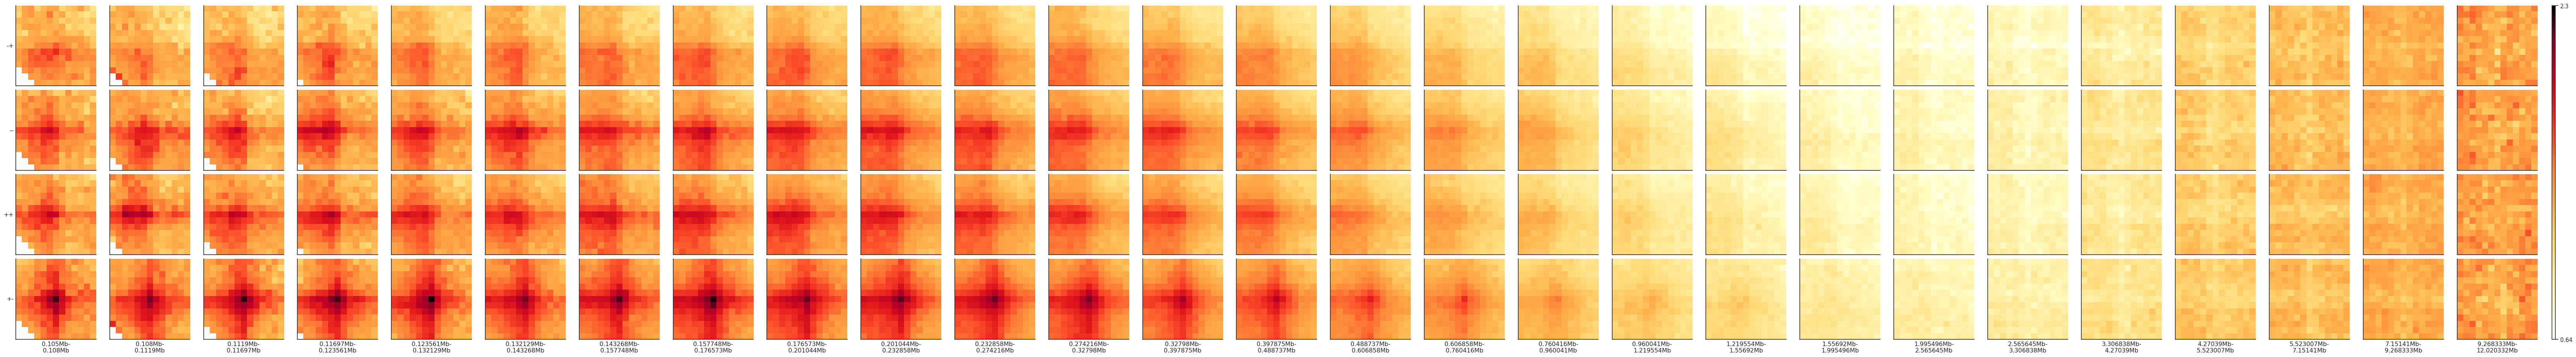

Wapl-24h_new liu_wapl24h.mm10.mapq_30.1000.mcool /project/fudenber_735/GEO/liu_deWit_2021_GSE135180/distiller-mm10/results/coolers_library/liu_wapl24h.mm10.mapq_30.1000.mcool


INFO:coolpuppy:('chr18', 'chr18'): 9683
INFO:coolpuppy:('chr16', 'chr16'): 13613
INFO:coolpuppy:('chr13', 'chr13'): 15480
INFO:coolpuppy:('chr3', 'chr3'): 16970
INFO:coolpuppy:('chr12', 'chr12'): 19828
INFO:coolpuppy:('chr14', 'chr14'): 20689
INFO:coolpuppy:('chr19', 'chr19'): 24133
INFO:coolpuppy:('chr1', 'chr1'): 24021
INFO:coolpuppy:('chr10', 'chr10'): 34505
INFO:coolpuppy:('chr9', 'chr9'): 37780
INFO:coolpuppy:('chr15', 'chr15'): 38935
INFO:coolpuppy:('chr6', 'chr6'): 38436
INFO:coolpuppy:('chr17', 'chr17'): 44745
INFO:coolpuppy:('chr8', 'chr8'): 50540
INFO:coolpuppy:('chr7', 'chr7'): 61347
INFO:coolpuppy:('chr2', 'chr2'): 69227
INFO:coolpuppy:('chr4', 'chr4'): 84266
INFO:coolpuppy:('chr11', 'chr11'): 96008
INFO:coolpuppy:('chr5', 'chr5'): 124434
INFO:coolpuppy:Total number of piled up windows: 824640


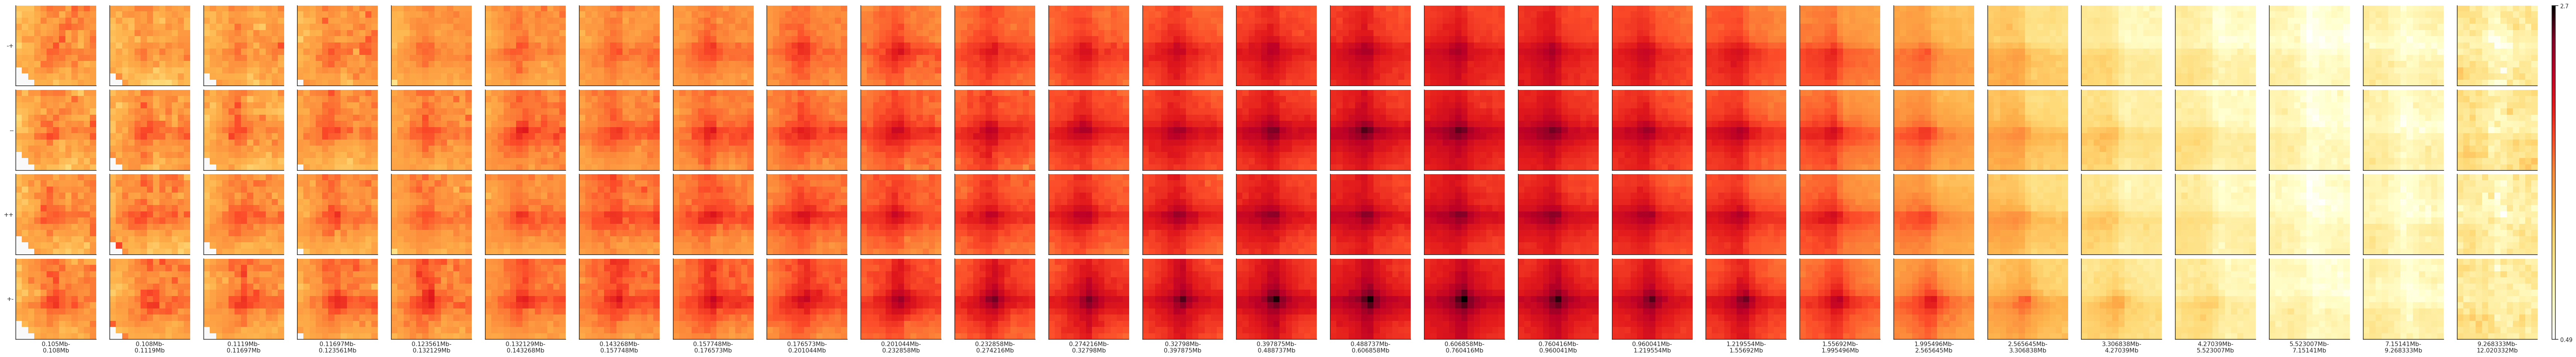

In [40]:
sites=peaks_motifs_quartile.copy()


beginning = 105_000
mindist = 95_000
band_edges = np.append([beginning], 95_000 + 10_000 * 1.3 ** np.arange(1,34))
band_edge_list=list(band_edges[:])
#pseudocount = 10./clr.info['sum']
print(band_edge_list)

for sample in sample_dict:
    f=open('data/dots_vs_distance_peaks_motifs_%s_obsvexp_Liu.csv'%sample,'w')
    f.write('orientation,dist,peak_score\n')
    mcool_path =  cooler_prefix + sample_dict[sample]
    print(sample,sample_dict[sample],mcool_path)
    clr = cooler.Cooler(mcool_path+'::resolutions/'+str(res))
    view_df = cooltools.lib.make_cooler_view(clr)[:19]
    expected = expected_cis(
    clr,
    ignore_diags=0,
    view_df=view_df[:19],
    chunksize=1000000)
    pup = coolpup.pileup(clr, 
                         sites, 
                         features_format='bed', view_df=view_df[:19],
                         expected_df=expected,
                         flip_negative_strand=True,
                         by_distance=np.array(band_edges),
                         by_strand=True, mindist=mindist, maxdist=10_000_000,
                        flank=60_000, min_diag=2,
                        nproc=19
                        )
    for i in range(len(pup['data'])):
        pseudocount = np.mean(np.isfinite(pup['data'][i]))/1000
        #print(pseudocount)
        #pseudocount = 10./clr.info['sum']
        #print(pseudocount)
        score=peak_score(pup['data'][i],3,5,pseudocount)
        #print(score)
        if pup['separation'][i]=='all':
            continue
        
        dist=np.mean(pup['distance_band'][i])
        orientation=pup['orientation'][i]
        f.write('%s,%s,%s\n'%(orientation,dist,score))
    fg = plotpup.plot(pup,  rows='orientation',cols='separation',
                  row_order=['-+', '--', '++', '+-'],score=False, 
                  cmap='fall', 
                  scale='log', sym=False,
                  height=3)
    
    plt.show()
    f.close()

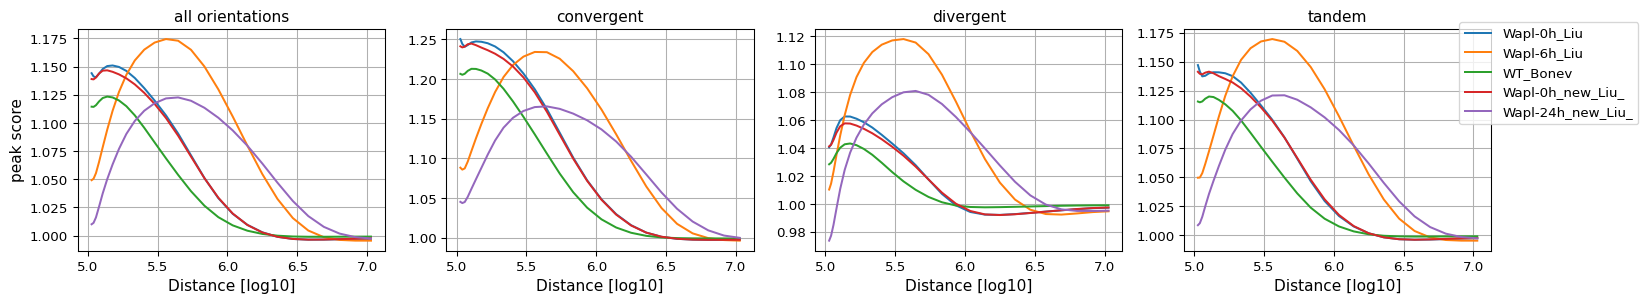

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(19, 3))  # 3 rows, 1 column

new_sample_dict =['Wapl-0h_Liu','Wapl-6h_Liu','WT_Bonev', 'Wapl-0h_new_Liu_','Wapl-24h_new_Liu_']


def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('data/dots_vs_distance_peaks_motifs_%s.csv'%name)
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    axs[1].plot(np.log10(dist_conv),smooth(score_conv),label='%s'%name)
    axs[0].plot(np.log10(dist_conv),smooth(score_ave),label='%s'%name)
    axs[2].plot(np.log10(dist_conv),smooth(score_dive),label='%s'%name)
    axs[3].plot(np.log10(dist_conv), smooth(score_tandemp), label='%s'%name)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
axs[1].set_title('convergent', fontsize = 11.5)
axs[2].set_title('divergent', fontsize = 11.5)
axs[3].set_title('tandem', fontsize = 11.5)
axs[0].set_title('all orientations', fontsize = 11.5)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance [log10]', fontsize = 11.5)
    #ax.set_ylim(0.95,1.35)
axs[3].legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs[0].set_ylabel('peak score',fontsize = 11.5)

#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('observed_for_ctcf&motifs_from_papers.png', bbox_inches = 'tight')
plt.show()

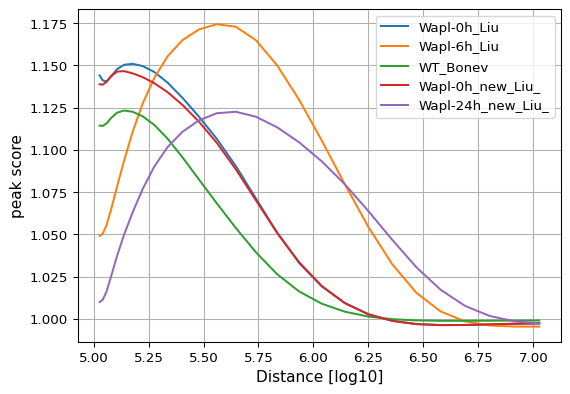

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-0h_Liu','Wapl-6h_Liu','WT_Bonev', 'Wapl-0h_new_Liu_','Wapl-24h_new_Liu_']


def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('data/dots_vs_distance_peaks_motifs_%s.csv'%name)
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    axs.plot(np.log10(dist_conv),smooth(score_ave),label='%s'%name)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
#axs.set_title('all orientations', fontsize = 11.5)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 11.5)
#ax.set_ylim(0.95,1.35)
#axs.legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs.legend()
axs.set_ylabel('peak score',fontsize = 11.5)

#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('observed_for_ctcf&motifs_from_papers_d.png', bbox_inches = 'tight')
plt.show()

Wapl-24h_new_Liu 1.0961826698532147
Wapl-0h_new_Liu 1.0976061567793214


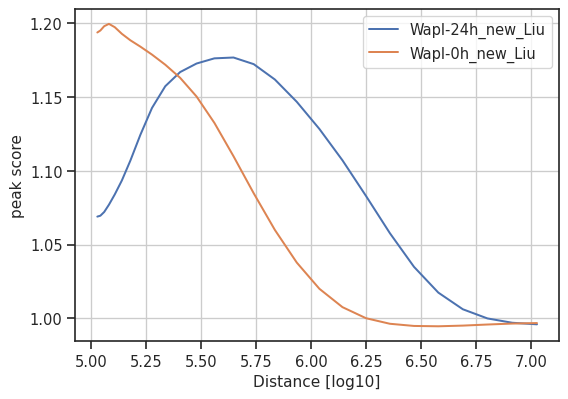

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-24h_new_Liu','Wapl-0h_new_Liu',]


def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('data/dots_vs_distance_peaks_motifs_%s_top_quart.csv'%name)
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    print(name,np.mean(score_ave))
    axs.plot(np.log10(dist_conv),smooth(score_ave),label='%s'%name)
#axs.set_ylim(0.9, 1.195)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
#axs.set_title('all orientations', fontsize = 11.5)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 11.5)
#ax.set_ylim(0.95,1.35)
#axs.legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs.legend()
axs.set_ylabel('peak score',fontsize = 11.5)

#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('observed_for_ctcf&motifs_from_papers_d.png', bbox_inches = 'tight')
plt.show()

Wapl-6h_Liu 1.1457865338069961
Wapl-0h_Liu 1.1102375467141288


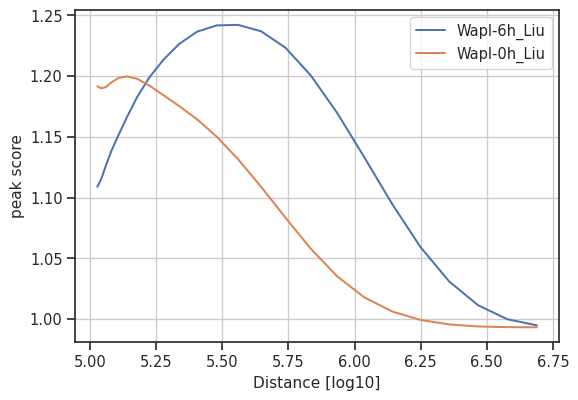

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu',]


def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('data/dots_vs_distance_peaks_motifs_%s_top_quart.csv'%name)
    data=data[data['dist']<=10**6.75]
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    print(name,np.mean(score_ave))
    axs.plot(np.log10(dist_conv),smooth(score_ave),label='%s'%name)
#axs.set_ylim(0.9, 1.195)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
#axs.set_title('all orientations', fontsize = 11.5)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 11.5)
#ax.set_ylim(0.95,1.35)
#axs.legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs.legend()
axs.set_ylabel('peak score',fontsize = 11.5)

#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('observed_for_ctcf&motifs_from_papers_top_quart.pdf', bbox_inches = 'tight')
plt.show()

In [48]:
data=pd.read_csv('data/dots_vs_distance_peaks_motifs_%s_top_quart.csv'%name)
data=data[data['dist']<=10**6.75]
data

,orientation,dist,peak_score
0,++,106500.0,1.241487
1,++,109950.0,1.177519
2,++,114435.0,1.188978
3,++,120265.5,1.206858
4,++,127845.0,1.154490
...,...,...,...
100,--,1776208.0,0.995024
101,--,2280570.5,0.990032
102,--,2936241.5,0.992101
103,--,3788614.0,0.993572


In [8]:
print(np.mean(score_ave))

1.0766157807663082


Wapl-24h 1.1669394255993348
Wapl-0h 1.1184690477304626


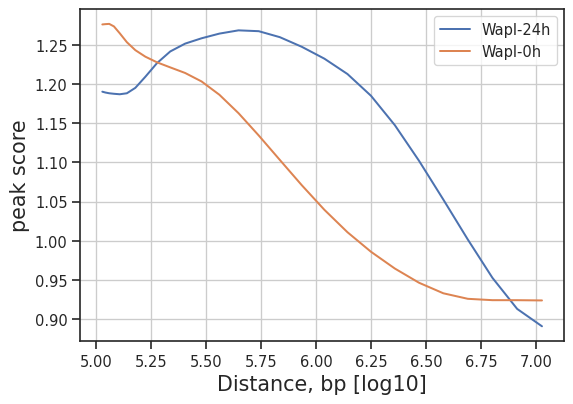

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-24h','Wapl-0h',]


def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)
for name in new_sample_dict[:15]:
    #print(name)
    data=pd.read_csv('data/dots_vs_distance_peaks_motifs_%s_new_obsvexp_Liu.csv'%name)
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    print(name,np.mean(score_ave))
    axs.plot(np.log10(dist_conv),smooth(score_ave),label='%s'%name)
#axs.set_ylim(0.9, 1.195)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
#axs.set_title('all orientations', fontsize = 11.5)
axs.grid(True)
axs.set_xlabel('Distance, bp [log10]', fontsize = 15.5)
#ax.set_ylim(0.95,1.35)
#axs.legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs.legend()
axs.set_ylabel('peak score',fontsize = 15.5)

#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
#plt.savefig('observed_for_ctcf&motifs_from_papers_d.png', bbox_inches = 'tight')
plt.show()